# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

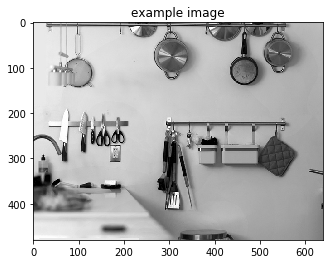

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 300
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding_layer): Embedding(9955, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 10, 21, 3, 57, 86, 56, 86, 6, 3, 152, 18, 1, 1, 320, 18, 1, 1, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(output):
    
    words_sequence = []
    
    for i in output:
        if (i == 1):
            continue
        words_sequence.append(data_loader.dataset.vocab.idx2word[i])
    
    words_sequence = words_sequence[1:-1] 
    sentence = ' '.join(words_sequence) 
    sentence = sentence.capitalize()
    
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A bathroom with a toilet , sink , and a mirror . towels


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

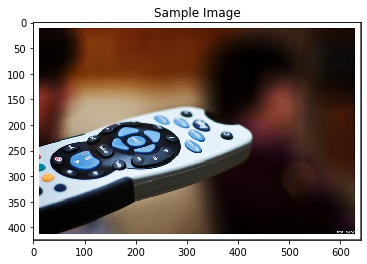

A person holding a wii controller with a remote control . .


In [9]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

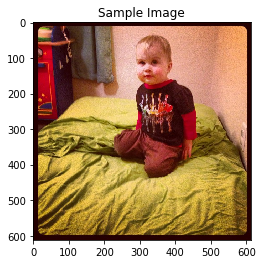

A woman laying on a bed with a cat on her lap . a book


In [10]:
get_prediction()

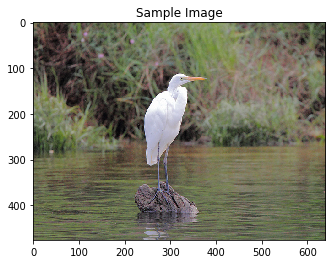

A bird sitting on a branch in the sun


In [11]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

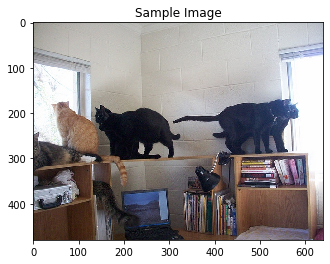

A cat sitting on a chair in a living room . from the heat


In [12]:
get_prediction()

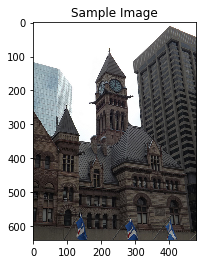

A clock tower with a clock on it 's side . a building .


In [13]:
get_prediction()

In [14]:
data_loader.dataset.vocab.idx2word


{0: '<start>',
 1: '<end>',
 2: '<unk>',
 3: 'a',
 4: 'very',
 5: 'clean',
 6: 'and',
 7: 'well',
 8: 'decorated',
 9: 'empty',
 10: 'bathroom',
 11: 'panoramic',
 12: 'view',
 13: 'of',
 14: 'kitchen',
 15: 'all',
 16: 'its',
 17: 'appliances',
 18: '.',
 19: 'blue',
 20: 'white',
 21: 'with',
 22: 'butterfly',
 23: 'themed',
 24: 'wall',
 25: 'tiles',
 26: 'photo',
 27: 'dining',
 28: 'room',
 29: 'stop',
 30: 'sign',
 31: 'across',
 32: 'the',
 33: 'street',
 34: 'from',
 35: 'red',
 36: 'car',
 37: 'vandalized',
 38: 'beetle',
 39: 'on',
 40: 'road',
 41: 'border',
 42: 'butterflies',
 43: 'paint',
 44: 'walls',
 45: 'above',
 46: 'it',
 47: 'an',
 48: 'angled',
 49: 'beautifully',
 50: 'two',
 51: 'people',
 52: 'are',
 53: 'walking',
 54: 'down',
 55: 'beach',
 56: 'sink',
 57: 'toilet',
 58: 'inside',
 59: 'small',
 60: 'black',
 61: 'square',
 62: 'tile',
 63: 'floor',
 64: 'that',
 65: 'needs',
 66: 'repairs',
 67: 'vanity',
 68: 'contains',
 69: 'sinks',
 70: 'towel',
 71: 'f

In [20]:
# generate result, 100 samples
from data_loader_val import get_loader
import json

transform_val = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])

# Create the data loader.
data_loader_val = get_loader(transform=transform_val,    
                         mode='val')

NumSample = 100
resultDir = '/opt/cocoapi/results'
result = []

for i in range(NumSample):
    orig_image, image, img_id = next(iter(data_loader_val))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    result.append({"image_id": img_id.item(), "caption": sentence})

with open(resultDir+'/captions_val2014_results.json', "w") as outfile: 
    outfile.write(json.dumps(result)) 

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  1%|▍                                                                        | 1057/202654 [00:00<00:19, 10468.75it/s]

Done (t=0.31s)
creating index...
index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 202654/202654 [00:19<00:00, 10371.36it/s]


In [21]:
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

# set up file names and pathes
dataDir='/opt/cocoapi'
dataType='val2014'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s.json'%(dataDir,dataType,subtype) for subtype in subtypes] # result dir

# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
tokenization...
setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 1172, 'reflen': 1123, 'guess': [1172, 1072, 972, 872], 'correct': [669, 301, 119, 47]}
ratio: 1.0436331255556157
Bleu_1: 0.571
Bleu_2: 0.400
Bleu_3: 0.270
Bleu_4: 0.180
computing METEOR score...


OSError: [Errno 22] Invalid argument